# AIRBNB EN LA CIUDAD DE MÉXICO: ANÁLISIS EXPLORATORIO Y DESCRIPTIVO

1. Introducción.

2.  Análisis explloratorio (EDA).
   - Correcciones al conjunto de datos.
   - Análisis de datos faltantes.
   - Selección de variables.
   - Descripción de variables.
   - Análisis de outliers.
   - Correlaciones

3. Precios.

4. Características del Airbnb.

5. Análisis temporal.

6. Espacios y servicios.

7. Ocupación mínima y máxima.

8. Tiempo y tasa de respuesta, tasa de aceptación y verificaciones.

9. Modelo explicativo.

10. Conclusiones.

# Introducción

El objetivo de este trabajo es realizar un Análisis Exploratorio de Datos (EDA) riguroso de la base oficial de Airbnb para la Ciudad de México y, a partir de él, construir un análisis descriptivo que permita caracterizar el mercado desde tres ejes: precio, espacio/geografía y comportamiento del anfitrión. La idea central no es “buscar un solo hallazgo”, sino mapear patrones robustos y establecer un marco técnico que sirva como base para análisis posteriores más específicos (por ejemplo, por perfil de usuario o por objetivo de negocio).

El EDA incluye correcciones y estandarización de variables, diagnóstico de datos faltantes, selección de variables relevantes, descripción de las principales covariables, análisis de outliers y evaluación de asociaciones entre variables mediante medidas adecuadas al tipo de dato. Esta etapa busca asegurar que las conclusiones descriptivas posteriores no dependan de artefactos del dataset (errores de formato, valores extremos inconsistentes o categorías mal codificadas), sino de patrones replicables.

La parte descriptiva profundiza en: (i) la distribución del precio, su asimetría y su relación con variables estructurales del alojamiento; (ii) la distribución espacial del servicio, identificando zonas sistemáticamente más caras o más accesibles y conectando estos patrones con la antigüedad del mercado; (iii) características del inmueble (capacidad, dormitorios, baños, etc.); (iv) presencia de amenities comunes; y (v) métricas del anfitrión como tiempo y tasa de respuesta y tasa de aceptación, útiles para evaluar calidad operativa y posibles filtros de actividad.

Este estudio no pretende construir un modelo predictivo de precio ni optimizar desempeño con fines operativos. En cambio, incorpora un modelo explicativo como herramienta de síntesis: su función es validar si los patrones observados en el análisis exploratorio se sostienen cuando se consideran múltiples variables simultáneamente (ubicación, tipo de alojamiento y características físicas), y no como un sistema de predicción listo para producción.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import folium
import folium.plugins as plugins
from folium.plugins import Geocoder
from matplotlib import colormaps
import ast
from wordcloud import WordCloud
import re
from collections import Counter
from rapidfuzz import fuzz
import warnings
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf
from pandas.errors import SettingWithCopyWarning

warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

listings = pd.read_csv("listings.csv")
reviews = pd.read_csv("reviews.csv")

- Análisis exploratorio (detección y tratamiento de outliers, datos faltantes y correcciones en general).
- Análisis de precios (tendencias, distribución geográfica, alcaldías).
- Características generales del inmueble (tipo, cupo máximo, distribución del número de habitaciones, baños, camas).
- Análisis temporal (serie de tiempo de aperturas del servicio por año).

# Análisis exploratorio (EDA)
- Correcciones al conjunto de datos.
- Análisis de datos faltantes.
- Selección de variables.
- Descripción de datos.
- Análisis de outliers.
- Correlaciones

## Correcciones

In [2]:
# Hacer una copia de los datos.
data1 = listings.copy()

# Eliminar duplicados si los hay.
data1.drop_duplicates(inplace = True)

# Corregir columna de precios.
data1["price"] = data1["price"].str.replace("$", "", regex = False).str.replace(",", "").str.strip().astype(float)

# Corregir columnas de tasa de respuesta y de aceptación.
data1["host_response_rate"] = data1["host_response_rate"].str.replace("%", "", regex = False).str.strip().astype(float)
data1["host_acceptance_rate"] = data1["host_acceptance_rate"].str.replace("%", "", regex = False).str.strip().astype(float)

# Convertir variables categóricas de texto a categorías ordinales.
mapa = {"within an hour": 1, "within a few hours": 2, "within a day": 3, "a few days or more": 4,}
data1["host_response_time"] = data1["host_response_time"].map(mapa).astype(pd.Int64Dtype())

# Considerar como categóricas las variables que lo sean.
data1["neighbourhood_cleansed"] = data1["neighbourhood_cleansed"].astype("category")
data1["room_type"] = data1["room_type"].astype("category")

## Análisis de datos faltantes y selección de variables

In [3]:
cols = data1.columns
tipos = data1.dtypes
nulos = data1.isna().sum()
no_nulos = data1.notna().sum()

dft1 = pd.DataFrame({"Columna": cols, "Tipos": tipos, "No nulos": no_nulos, "Nulos": nulos}).iloc[0:40, :].reset_index(drop = True)
dft2 = pd.DataFrame({"Columna": cols, "Tipos": tipos, "No nulos": no_nulos, "Nulos": nulos}).iloc[40:80, :].reset_index(drop = True)
pd.concat([dft1, dft2], axis = 1)

,Columna,Tipos,No nulos,Nulos,Columna,Tipos,No nulos,Nulos
0,id,int64,26401,0,price,float64,23127.0,3274.0
1,listing_url,object,26401,0,minimum_nights,int64,26401.0,0.0
2,scrape_id,int64,26401,0,maximum_nights,int64,26401.0,0.0
3,last_scraped,object,26401,0,minimum_minimum_nights,float64,26381.0,20.0
4,source,object,26401,0,maximum_minimum_nights,float64,26381.0,20.0
5,name,object,26401,0,minimum_maximum_nights,float64,26381.0,20.0
6,description,object,25633,768,maximum_maximum_nights,float64,26381.0,20.0
7,neighborhood_overview,object,13970,12431,minimum_nights_avg_ntm,float64,26401.0,0.0
8,picture_url,object,26401,0,maximum_nights_avg_ntm,float64,26401.0,0.0
9,host_id,int64,26401,0,calendar_updated,float64,0.0,26401.0


- Eliminaremos algunas variables que no son relevantes para los fines de este análisis (se omite la justificación para evitar saturar el notebook): ``listing_url``, ``scrape_id``, ``last_scraped``, ``source``, ``name``, ``neighborhood_overview``, ``picture_url``, ``host_id``, ``host_url``, ``host_name``, ``host_location``, ``host_about``, ``host_is_superhost``, ``host_thumbnail_url``, ``host_picture_url``, ``host_neighbourhood``, ``neighbourhood``, ``host_has_profile_pic``, ``neighbourhood_group_cleansed``, ``property_type``, ``minimum_minimum_nights``, ``maximum_minimum_nights``, ``minimum_maximum_nights``, ``maximum_maximum_nights``, ``minimum_nights_avg_ntm``, ``maximum_nights_avg_ntm``, ``calendar_updated``, ``has_availability``, ``availability_30``, ``availability_60``, ``availability_90``, ``availability_365``, ``calendar_last_scraped``, ``number_of_reviews_ltm``, ``number_of_reviews_l30d``, ``availability_eoy``, ``number_of_reviews_ly``, ``estimated_occupancy_l365d``, ``estimated_revenue_l365d``, ``first_review``, ``last_review``, ``review_scores_rating``, ``review_scores_accuracy``, ``review_scores_cleanliness``, ``review_scores_checkin``, ``review_scores_communication``, ``review_scores_location``, ``review_scores_value``, ``license``, ``instant_bookable``, ``calculated_host_listings_count``, ``calculated_host_listings_count_entire_homes``, ``calculated_host_listings_count_private_rooms``, ``calculated_host_listings_count_shared_rooms``, ``reviews_per_month``, 
- Hay muchas variables que caracterizan como tal a los hospedadores. Sin embargo, este análisis no tiene como objetivo estudiar a los hospedadores, sino a los servicios que ofrecen.

In [4]:
lista1 = ["listing_url", "scrape_id", "last_scraped", "source", "name", "neighborhood_overview", "picture_url", "host_id", "host_url",
          "host_name", "host_location", "host_about", "host_is_superhost",  "host_thumbnail_url", "host_picture_url", "host_neighbourhood",
          "neighbourhood", "host_has_profile_pic", "neighbourhood_group_cleansed", "minimum_minimum_nights", "maximum_minimum_nights",
          "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "calendar_updated",
          "has_availability", "availability_30", "availability_60", "availability_90", "availability_365", "calendar_last_scraped",
          "number_of_reviews_ltm", "number_of_reviews_l30d","availability_eoy", "number_of_reviews_ly", "estimated_occupancy_l365d",
          "estimated_revenue_l365d", "first_review", "last_review", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness",
          "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "license", "instant_bookable",
          "calculated_host_listings_count", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms",
          "calculated_host_listings_count_shared_rooms", "reviews_per_month", "property_type"]

data1 = data1.drop(columns = lista1)

cols = data1.columns
tipos = data1.dtypes
nulos = data1.isna().sum()
no_nulos = data1.notna().sum()
total = len(data1)
porc_null = round((nulos/total) * 100)

dft1 = pd.DataFrame({"Columna": cols, "Tipos": tipos, "No nulos": no_nulos, "Nulos": nulos, "% nulos": porc_null}).iloc[0:12, :].reset_index(drop = True)
dft2 = pd.DataFrame({"Columna": cols, "Tipos": tipos, "No nulos": no_nulos, "Nulos": nulos, "% nulos": porc_null}).iloc[12:24, :].reset_index(drop = True)
pd.concat([dft1, dft2], axis = 1)

,Columna,Tipos,No nulos,Nulos,% nulos,Columna,Tipos,No nulos,Nulos,% nulos
0,id,int64,26401,0,0.0,longitude,float64,26401,0,0.0
1,description,object,25633,768,3.0,room_type,category,26401,0,0.0
2,host_since,object,25487,914,3.0,accommodates,int64,26401,0,0.0
3,host_response_time,Int64,21715,4686,18.0,bathrooms,float64,23120,3281,12.0
4,host_response_rate,float64,21715,4686,18.0,bathrooms_text,object,26370,31,0.0
5,host_acceptance_rate,float64,22791,3610,14.0,bedrooms,float64,25477,924,3.0
6,host_listings_count,float64,25487,914,3.0,beds,float64,23104,3297,12.0
7,host_total_listings_count,float64,25487,914,3.0,amenities,object,26401,0,0.0
8,host_verifications,object,25487,914,3.0,price,float64,23127,3274,12.0
9,host_identity_verified,object,25487,914,3.0,minimum_nights,int64,26401,0,0.0


- Algunas variables tienen datos faltantes. Sin embargo, estos porcentajes no son alarmantes dado que nuestros fines no son de predicción, sino de descripción. Por lo tanto, es razonable pensar que las muestras (llamémosle así a aquellos casos en los que los datos no están completos) representan bien a la poblacíón.

## Descripción de variables.

- `id`. Identificador único del anuncio.
- `description`. Descripción general del alojamiento publicada por el anfitrión.
- `host_since`. Fecha en que el anfitrión se unió a Airbnb.
- `host_response_time`. Tiempo típico de respuesta del anfitrión a mensajes.
- `host_response_rate`. Porcentaje de mensajes a los que el anfitrión responde.
- `host_acceptance_rate`. Porcentaje de solicitudes de reserva que el anfitrión acepta.
- `host_listings_count`. Número de anuncios del anfitrión incluidos en este dataset o región.
- `host_total_listings_count`. Número total de anuncios del anfitrión en Airbnb, en cualquier ubicación.
- `host_verifications`. Conjunto de métodos de verificación de identidad completados por el anfitrión.
- `host_identity_verified`. Indicador binario que señala si Airbnb ha verificado la identidad del anfitrión.
- `neighbourhood_cleansed`. Barrio estandarizado donde se ubica el anuncio.
- `latitude`. Latitud geográfica del anuncio.
- `longitude`. Longitud geográfica del anuncio.
- `room_type`. Tipo de espacio ofrecido al huésped, asociado al nivel de privacidad del alojamiento.
- `accommodates`. Número máximo de personas que puede alojar el anuncio.
- `bathrooms`. Número de baños.
- `bathrooms_text`. Descripción textual del número y tipo de baños.
- `bedrooms`. Número de dormitorios separados del alojamiento.
- `beds`. Número total de camas disponibles.
- `amenities`. Lista de servicios y comodidades ofrecidas por el alojamiento.
- `price`. Precio por noche del alojamiento.
- `minimum_nights`. Número mínimo de noches requeridas para aceptar una reserva.
- `maximum_nights`. Número máximo de noches permitidas por reserva.
- `number_of_reviews`. Número total de reseñas recibidas por el anuncio.

## Análisis de outliers

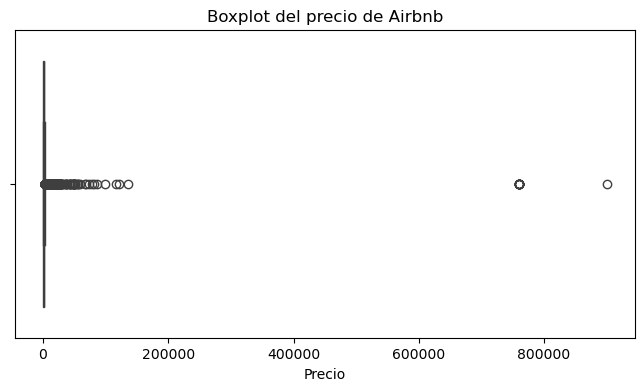

In [5]:
# Eliminar registros que no tienen precio.
data2 = data1.dropna(subset=["price"]).copy()

plt.figure(figsize=(8, 4))
sns.boxplot(x=data2["price"])
plt.title("Boxplot del precio de Airbnb")
plt.xlabel("Precio")
plt.show()

- El boxplot anterior muestra algunos outliers: precios demasiado elevados en comparación con los demás. Exploremos las razones para saber si son errores de registro o si hay alguna explicación del costo tan elevado.

In [6]:
#pd.set_option("display.max_colwidth", None)
#pd.set_option("display.max_rows", None)

outliers = data2[data2["price"] > 200000]
outliers[["description", "neighbourhood_cleansed", "price", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "amenities"]]

,description,neighbourhood_cleansed,price,room_type,accommodates,bathrooms,bedrooms,beds,amenities
15080,"Comfortable, spacious rental bedroom, inside t...",Tlalpan,900000.0,Private room,1,1.0,1.0,1.0,"[""Piano"", ""Blender"", ""Coffee maker: drip coffe..."
19122,The hotel is situated in a lively metropolis i...,Cuauhtémoc,759762.0,Hotel room,2,1.0,1.0,1.0,"[""Coffee maker"", ""Dedicated workspace"", ""Heati..."
19132,The hotel is situated in a lively metropolis i...,Cuauhtémoc,759762.0,Hotel room,6,3.0,3.0,3.0,"[""Coffee maker"", ""Dedicated workspace"", ""Heati..."
19133,The hotel is situated in a lively metropolis i...,Cuauhtémoc,759762.0,Hotel room,6,3.0,3.0,3.0,"[""Coffee maker"", ""Dedicated workspace"", ""Heati..."
19134,The hotel is situated in a lively metropolis i...,Cuauhtémoc,759762.0,Hotel room,2,1.0,1.0,1.0,"[""Dedicated workspace"", ""TV"", ""First aid kit"",..."
19138,The hotel is situated in a lively metropolis i...,Cuauhtémoc,759762.0,Hotel room,4,2.0,2.0,2.0,"[""Coffee maker"", ""Dedicated workspace"", ""Heati..."
19139,The hotel is situated in a lively metropolis i...,Cuauhtémoc,759762.0,Hotel room,4,2.0,2.0,2.0,"[""Coffee maker"", ""Dedicated workspace"", ""Heati..."
20442,The hotel is situated in a lively metropolis i...,Cuauhtémoc,759762.0,Private room,2,1.0,1.0,1.0,"[""Coffee maker"", ""Dedicated workspace"", ""Heati..."
20478,The hotel is situated in a lively metropolis i...,Cuauhtémoc,759762.0,Private room,2,1.0,1.0,1.0,"[""Coffee maker"", ""Dedicated workspace"", ""Heati..."
20481,Pet-Friendly Hotel with Shuttle & Spa Wander t...,Cuauhtémoc,759762.0,Private room,2,1.0,1.0,1.0,"[""Hangers"", ""Essentials"", ""Coffee maker"", ""Wif..."


- En general, para los 13 outliers los precios están por arriba de los $\$$700 000, habiendo uno que incluso alcanza los $\$$900 000 por noche.
- Lo anterior no tiene sentido de acuerdo con su descripción y los espacios que ofrece. La mayoría son habitaciones en  un hotel o una habitación privada dentro de una casa, ofreciendo espacios y servicios muy similares a casi cualquier otro Airbnb.
- Por lo tanto, vamos a eliminar estos outliers y reelaboraremos el boxplot.

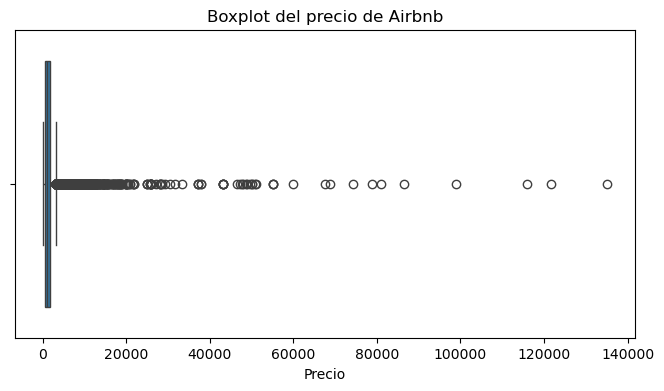

In [7]:
data_sin_out = data2[data2["price"] < 200000]
plt.figure(figsize=(8, 4))
sns.boxplot(x=data_sin_out["price"])
plt.title("Boxplot del precio de Airbnb")
plt.xlabel("Precio")
plt.show()

- Ahora los outliers no parecen tan extremos como en el caso anterior. Exploremos algunos de ellos para revisar si el precio es consistente con los espacios y servicios que ofrece.

In [8]:
pd.DataFrame(data_sin_out.sort_values(by = "price", ascending = False).head(8)[["description", "neighbourhood_cleansed", "price", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "amenities"]])

,description,neighbourhood_cleansed,price,room_type,accommodates,bathrooms,bedrooms,beds,amenities
9307,"A spacious apartment, New construction and tr...",Cuauhtémoc,135000.0,Entire home/apt,4,2.5,2.0,2.0,"[""Blender"", ""106 inch HDTV"", ""Coffee"", ""Wine g..."
6220,"It is a beautiful duplex house, with private r...",Cuauhtémoc,121600.0,Private room,10,3.0,5.0,1.0,"[""Essentials"", ""Kitchen"", ""Resort access"", ""Ha..."
26205,Discover comfort in this modern 2BR duplex on ...,Cuauhtémoc,115940.0,Entire home/apt,4,2.5,2.0,2.0,"[""Body soap"", ""Wine glasses"", ""Elevator"", ""Ded..."
18989,This place has a strategic location - it will ...,Miguel Hidalgo,99000.0,Entire home/apt,2,1.0,1.0,1.0,"[""TV"", ""Wifi"", ""Kitchen"", ""Free parking on pre..."
13634,Stunning secluded 1100 M2 Colonial Architectur...,Cuajimalpa de Morelos,86491.0,Entire home/apt,16,4.5,4.0,8.0,"[""Air conditioning"", ""Valley view"", ""Kitchen"",..."
5837,"Spacious interior apartment, surrounded and su...",Cuauhtémoc,81000.0,Entire home/apt,2,2.0,1.0,1.0,"[""Coffee maker"", ""Patio or balcony"", ""Kitchen""..."
23518,If you are looking for a comfortable and quiet...,Miguel Hidalgo,78841.0,Private room,2,1.0,1.0,1.0,"[""Clothing storage"", ""Blender"", ""Coffee maker""..."
3989,"It is a private space, with a continuous conv...",Miguel Hidalgo,74237.0,Entire home/apt,4,8.0,5.0,6.0,"[""Backyard"", ""Coffee maker"", ""Patio or balcony..."


- Note que la mayoría de ellos son casas completas, tienen capacidad para alojar varias personas, ofrecen varias habitaciones o habitaciones muy amuebladas, etc.
- Por lo tanto, estos outliers no serán eliminados, ya que hay una explicación con sentido para el precio elevado, sin que este sea extremo como en los casos anteriores.

In [9]:
data3 = data2[data2["price"] < 200000]

## Correlaciones

C:\Users\Administrador\AppData\Local\Temp\ipykernel_21444\2075906575.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby("cat")["num"]


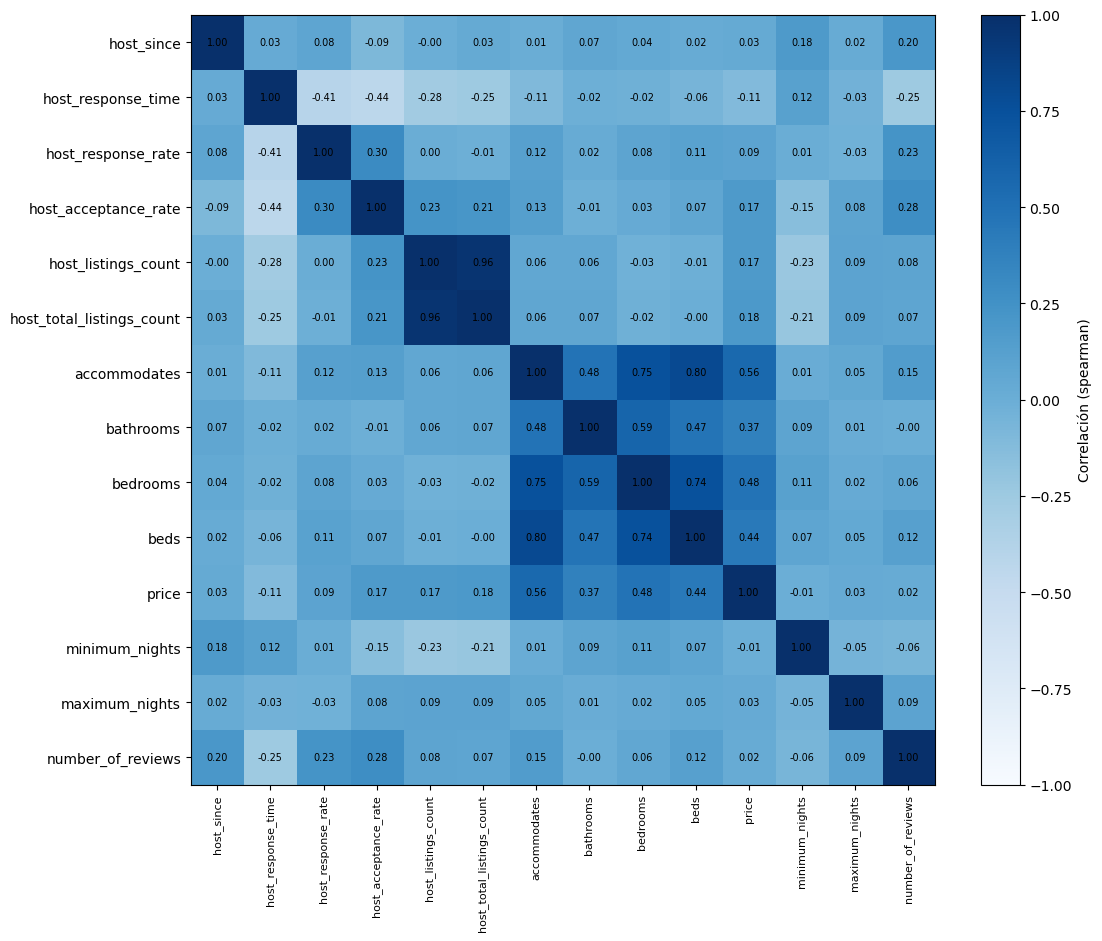

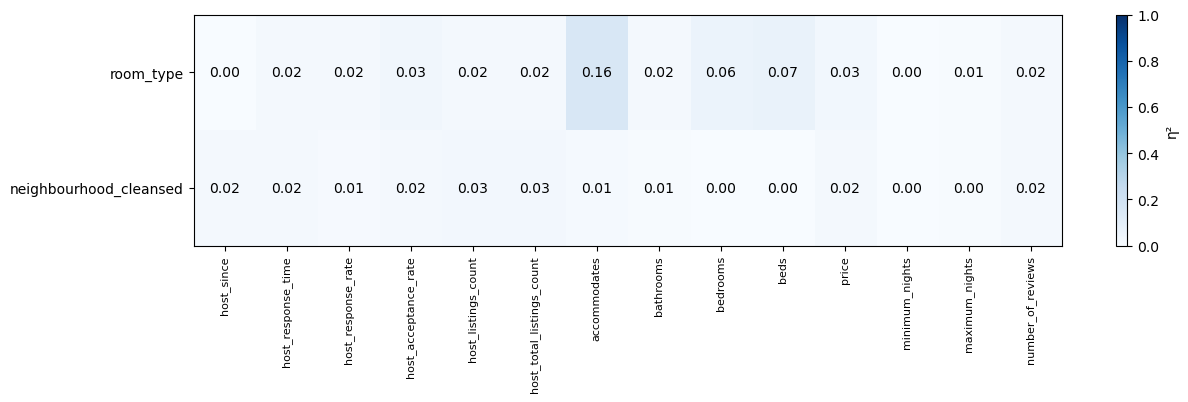

In [10]:
data3b = data3[["host_since", "host_response_time", "host_response_rate", "host_acceptance_rate", "host_listings_count",
                "host_total_listings_count", "neighbourhood_cleansed", "room_type", "accommodates", "bathrooms", "bedrooms",
                "beds", "price", "minimum_nights", "maximum_nights", "number_of_reviews"]].copy()

data3b["host_since"] = pd.to_datetime(data3b["host_since"], errors = "coerce")

data3b["host_since"] = round(((pd.Timestamp.today() - data3b["host_since"]).dt.days / 365.25), 2)

data3c = data3b.drop(columns = ["neighbourhood_cleansed", "room_type"])

# Matriz de correlaciones de "Pearson" para variables numéricas (incluidas las ordinales).
X = data3c.select_dtypes(include=[np.number])
corr = X.corr(method="spearman")

plt.figure(figsize=(12, 10))
im = plt.imshow(corr.values, vmin=-1, vmax=1, cmap="Blues", aspect="auto")
plt.colorbar(im, label=f"Correlación ({"spearman"})")

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr.index)), corr.index, fontsize=10)

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        value = corr.values[i, j]
        if not np.isnan(value): plt.text(j, i, format(value, ".2f" ), ha="center", va="center", fontsize=7, color="black")

# Matriz de correlaciones de variables nominales contra las numéricas.
nominal_cols = ["room_type", "neighbourhood_cleansed"]
num_cols = [c for c in data3b.select_dtypes(include="number").columns if c not in nominal_cols]

def eta_squared(cat, num):
    df = pd.DataFrame({"cat": cat, "num": num}).dropna()
    if df.empty or df["cat"].nunique() <= 1 or df["num"].nunique() <= 1:
        return 0.0
    overall_mean = df["num"].mean()
    grp = df.groupby("cat")["num"]
    ss_between = (grp.count() * (grp.mean() - overall_mean) ** 2).sum()
    ss_total = ((df["num"] - overall_mean) ** 2).sum()
    return float(ss_between / ss_total) if ss_total > 0 else 0.0

M = pd.DataFrame(index=nominal_cols, columns=num_cols, dtype=float)
for nom in nominal_cols:
    for col in num_cols:
        M.loc[nom, col] = eta_squared(data3b[nom], data3b[col])

plt.figure(figsize=(14, 3))
im = plt.imshow(M.values, vmin=0, vmax=1, cmap="Blues", aspect="auto")
plt.colorbar(im, label="η²")

plt.xticks(range(len(M.columns)), M.columns, rotation=90, fontsize=8)
plt.yticks(range(len(M.index)), M.index, fontsize=10)

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        plt.text(j, i, format(M.values[i, j], ".2f"),
                 ha="center", va="center", fontsize=10, color="black")

- Se usaron dos tipos de asociaciones distintas: matriz de correlaciones de Spearman y matriz de asociación ($\eta^2$). La primera se usó para las variables numéricas (incluidas las ordinales que fueron tratadas previamente) y cuantifica cómo se mueven juntas dos variables cuantitativas u ordenables. La segunda se usó para las variables nominales contra el esto, y cuantifica la variabilidad que es explicada por pertenecer a una categoría.
- El grupo de variables más correlacionadas tiene que ver con el cupo máximo, el número de baños, habitaciones, camas y el precio. Casi todas estas tienen que ver con el tamaño del alojamiento.
- Existen correlaciones bajas a moderadas entre el tiempo de respuesta con la tasa de respuesta y la tasa de aceptación. Lo cual significa que mayores demoras en el tiempo de respuesta se asocian con menor tasa de respuesta y de aceptación.
- El número de reseñas está débilmente correlacionado con el tiempo y tasa de respuesta y la tasa de aceptación.
- También hay correlaciones muy débiles entre el tiempo de respuesta y el número de anuncios.
- El resto de correlaciones son demasiado bajas, por debajo del $|0.20|$.
- Observe que el precio tiene más correlación  con el bloque de características del inmueble como tal (cupo máximo, número de camas, habitaciones, etc.), por lo que probablemente estas variables serán útiles para predecir el precio. Sin embargo, esto no quiere decir que el resto de variables no serán útiles, ya que la correlación de Pearson cuantifica asociaciones lineales, pero ignora asociaciones no lineales.

# Precios
- Estadísticas generales del precio.
- Distribución de los logaritmos del precio.
- Mapa de promedios del precio y concentraciones de Airbnbs por alcaldía.
- Mapa de precio y cantidad de Airbnbs por área geográfica (celdas de $4\ km^2$).

In [11]:
# Precio promedio de un Airbnb.
print("\nEstadísticas generales sobre el precio:")
print(f"\nMedia = {(data3["price"].mean()).astype(int)}")
print(f"\nMediana = {round(data3["price"].median())}")
print(f"\nMínimo = {round(data3["price"].min())}")
print(f"\nMáximo = {round(data3["price"].max())}")
print(f"\nDesviación Estándar = {round(data3["price"].std())}")


Estadísticas generales sobre el precio:

Media = 1557

Mediana = 1039

Mínimo = 66

Máximo = 135000

Desviación Estándar = 3043


- La mediana es más pequeña que la media, esto sugiere que hay una cola larga hacia la derecha en la distribución, con algunos pocos Airbnb con costos muy altos.
- La desviación estándar es grande, lo cual indica una diferencia de precios que seguramente tiene que ver con el tamaño y servicios ofrecidos pero sobre todo con la zona geográfica en la que se encuentra, como se explorará más adelante.
- A continuación se muestra un histograma del logaritmo de los precios. Se maneja con logaritmos porque un histograma de los precios reales sería muy poco informativo por los outliers que no fueron eliminados.

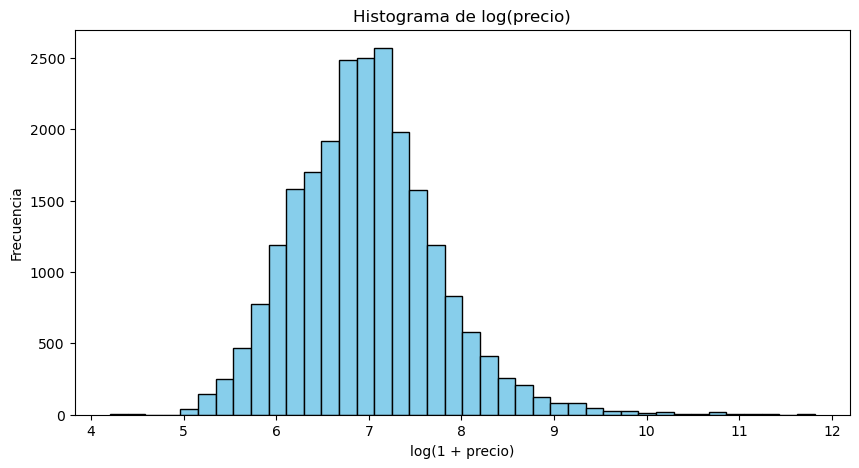

In [12]:
plt.figure(figsize=(10,5))
plt.hist(np.log1p(data3["price"]), bins=40, color="skyblue", edgecolor="black")
plt.title("Histograma de log(precio)")
plt.xlabel("log(1 + precio)")
plt.ylabel("Frecuencia");

Para interpretar lo anterior, convertimos de nuevo los números que nos interesan en sus precios originales de la siguiente manera:

$$\text{exp}(6)-1 = 402 \qquad \qquad \qquad \text{exp}(8)-1 = 2980$$

La mayoría de los datos en la gráfica se encuentran entre los números 6 y 8, por lo tanto, la gran mayoría de precios de los Airbnb están entre $\$$402 y $\$$2980.

In [13]:
print(round(np.exp(6)-1))
print(round(np.exp(8)-1))

402
2980


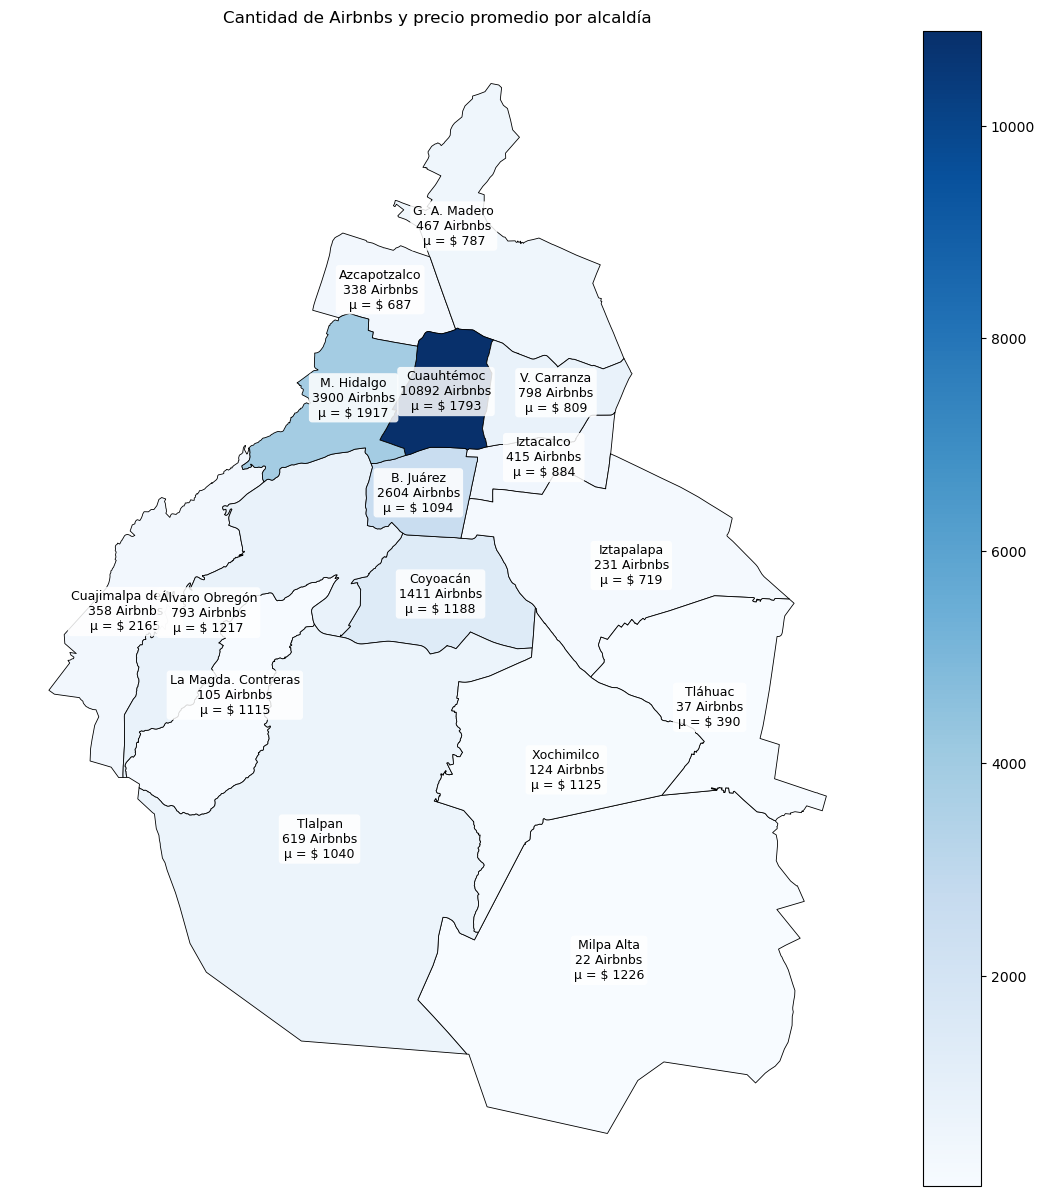

,Alcaldía,Territorio km^2,Total de Airbnbs,% del total,Densidad (Airbnb/km^2),Precio promedio,D. E. del precio,Máximo,Mínimo,Cuantil 0.05,Cuantil 0.95
0,Cuauhtémoc,32.5,10892,47.1,335.1,1793,3424,135000,66,389,4393
1,Miguel Hidalgo,46.4,3900,16.9,84.1,1917,3263,99000,176,432,4743
2,Benito Juárez,26.7,2604,11.3,97.5,1094,1934,50000,171,311,2389
3,Coyoacán,53.9,1411,6.1,26.2,1188,2524,48704,152,283,2811
4,Venustiano Carranza,33.8,798,3.5,23.6,809,634,9000,180,275,1690
5,Álvaro Obregón,95.8,793,3.4,8.3,1217,1789,25955,150,293,2725
6,Tlalpan,314.3,619,2.7,2.0,1040,2911,67500,165,233,2803
7,Gustavo A. Madero,87.8,467,2.0,5.3,787,1145,17800,153,233,1724
8,Iztacalco,23.1,415,1.8,18.0,884,643,5680,137,337,1951
9,Cuajimalpa de Morelos,71.1,358,1.5,5.0,2165,5901,86491,180,468,3827


In [14]:
# Texto ajustable.
FONT = 9  # tamaño del texto en el mapa.

# Diccionario de nombres cortos.
alias = {"Miguel Hidalgo": "M. Hidalgo", "Benito Juárez": "B. Juárez", "Venustiano Carranza": "V. Carranza", "Gustavo A. Madero": "G. A. Madero",
         "Cuajimalpa de Morelos": "Cuajimalpa de M.", "La Magdalena Contreras": "La Magda. Contreras"}

# Cargar polígonos.
gdf_alc = gpd.read_file("alcaldias/poligonos_alcaldias_cdmx.shp")
if gdf_alc.crs is None:
    gdf_alc = gdf_alc.set_crs("EPSG:4326")

name_col = next(
    c for c in gdf_alc.columns
    if c.lower() != "geometry" and any(k in c.lower() for k in ["alcal", "nom", "name"]))
gdf_alc = gdf_alc.rename(columns={name_col: "Alcaldía"})

# Crear puntos.
df_base = data3[["latitude", "longitude", "price"]].dropna(subset=["latitude", "longitude"]).copy()
df_base["price"] = pd.to_numeric(df_base["price"], errors="coerce")

gdf_pts = gpd.GeoDataFrame(df_base, geometry=gpd.points_from_xy(df_base["longitude"], df_base["latitude"]), crs="EPSG:4326")

# Asegurar CRS común.
if gdf_pts.crs != gdf_alc.crs:
    gdf_pts = gdf_pts.to_crs(gdf_alc.crs)

# Spatial join.
join = (gpd.sjoin(gdf_pts, gdf_alc[["Alcaldía", "geometry"]], how="left", predicate="within").dropna(subset=["Alcaldía"]))

# Área en km^2.
gdf_alc_m = gdf_alc.to_crs("EPSG:32614")
gdf_alc_m["Territorio km^2"] = (gdf_alc_m.geometry.area / 1e6).round(1)

# Estadísticos por alcaldía.
stats = (join.groupby("Alcaldía")["price"].agg(**{"Total de Airbnbs": "count", "Precio promedio": "mean", "Desviación estándar del precio": "std",
                                                  "Máximo": "max", "Mínimo": "min", "Cuantil 0.05": lambda x: x.quantile(0.05),
                                                  "Cuantil 0.95": lambda x: x.quantile(0.95),}).reset_index())

# Unir todo.
gdf_plot = gdf_alc_m.merge(stats, on="Alcaldía", how="left")

# Porcentaje del total.
gdf_plot["% del total"] = round((gdf_plot["Total de Airbnbs"] / gdf_plot["Total de Airbnbs"].sum()) * 100, 1)

# Densidad en Airbnb/km^2.
gdf_plot["Densidad (Airbnb/km^2)"] = round((gdf_plot["Total de Airbnbs"] / gdf_plot["Territorio km^2"]), 1)

# Nombre corto para el mapa.
gdf_plot["Alcaldía_corta"] = gdf_plot["Alcaldía"].replace(alias)

# Mapa coroplético.
fig, ax = plt.subplots(figsize=(15, 15))
gdf_plot.plot(column="Total de Airbnbs", cmap="Blues", legend=True, edgecolor="black", linewidth=0.6, ax=ax)
ax.set_title("Cantidad de Airbnbs y precio promedio por alcaldía")
ax.axis("off")

# Etiquetas: alcaldía + total + precio promedio.
for _, r in gdf_plot.dropna(subset=["Total de Airbnbs", "Precio promedio"]).iterrows():
    p = r.geometry.representative_point()
    ax.text(p.x, p.y, f"{r['Alcaldía_corta']}\n" f"{int(round(r['Total de Airbnbs']))} Airbnbs\n" f"µ = $ {int(round(r['Precio promedio']))}",
            ha="center", va="center", fontsize=FONT, bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.85))

plt.show()

# Tabla final.
tabla = gdf_plot[["Alcaldía", "Territorio km^2", "Total de Airbnbs", "% del total", "Densidad (Airbnb/km^2)", "Precio promedio",
                  "Desviación estándar del precio","Máximo", "Mínimo", "Cuantil 0.05", "Cuantil 0.95"]].copy()

tabla["Total de Airbnbs"] = tabla["Total de Airbnbs"].fillna(0).astype(int)
tabla["Precio promedio"] = tabla["Precio promedio"].round(0).astype("Int64")
tabla["Desviación estándar del precio"] = tabla["Desviación estándar del precio"].round(0).astype("Int64")
tabla = tabla.rename(columns={"Desviación estándar del precio": "D. E. del precio"})
tabla["Máximo"] = tabla["Máximo"].round(0).astype("Int64")
tabla["Mínimo"] = tabla["Mínimo"].round(0).astype("Int64")
tabla["Cuantil 0.05"] = tabla["Cuantil 0.05"].round(0).astype("Int64")
tabla["Cuantil 0.95"] = tabla["Cuantil 0.95"].round(0).astype("Int64")

tabla = tabla.sort_values("Total de Airbnbs", ascending=False).reset_index(drop=True)
tabla

- Cuauhtémoc, siendo una de las alcaldías más pequeñas en territorios tiene casi la mitad del total de Airbnbs que hay en la Ciudad de México. En contraste, Milpa Alta tiene apenas el 0.1 $\%$ del total de Airbnbs, siendo que es una de las alcaldías más grandes en territorio. Esto probablemente responda a la distribución de la población en la Ciudad de México, y también a lo turístico de cada zona.
- Relacionado a lo anterior, Cuauhtémoc tiene una densidad de 335 Airbnbs por km^2, lo cual significa que hay aproximadamente 3.35 Airbnbs por cada hectárea en esta alcaldía. Mientras que Milpa Alta tiene aproximadamente apenas 0.001 Airbnb por hectárea.
- Las alcaldías del centro, norte y este del centro concentran las mayores cantidades de Airbnbs.
- Cuajimalpa de Morelos es la alcaldía más cara en promedio ($\$$ 2165), y es más de cuatro veces el promedio de la alcaldía más barata (Tlahuac, $\$$ 390).
- En general, parece ser que las alcaldías del centro, este y sur son las zonas más caras de la ciudad.
- Se detecta el siguiente patrón: a mayor precio promedio, mayor desviación estándar. Lo cual podría sugerir que se trata de distribuciones con cola derecha larga, es decir, podría haber algunos Airbnbs con precios altos que sesguen  la derecha la distribución del precio.
- Resulta interesante que sea precisamente en Cuauhtémoc donde se encuentre el Airbnb más barato ($\$$ 66 por noche) y también el más caro ($\$$ 135 000 por noche).
- El cuantil 0.05 y el cuantil 0.95 son los límites del precio entre los que se encuentran el 90 % de los Airbnbs de esa alcaldía, es decir, el 90 % de Airbnbs tiene un precio que cae dentro de ese intervalo. El hecho de que el cuantil 0.95 de Cuauhtémoc sea considerablemente mayor que el de Cuajimalpa sugiere que, en efecto, la distribución del precio en Cuajimalpa podría tener un gran sesgo a la derecha, es decir, varios Airbnbs con precios mucho más caros que la tendencia, lo que provoca un aumento considerable de la media.

In [15]:
# Eliminar filas sin precio.
data_clean = data3.dropna(subset=["price"]).copy()

# Tamaño de la celda en km.
CELL_KM = 2.0

# Parámetros de visibilidad de la cuadrícula.
GRID_COLOR = "black"
GRID_OPACITY = 0.50
GRID_WEIGHT = 1

# Centro para convertir entre kilómetros y grados.
lat0 = data_clean["latitude"].mean()
lon0 = data_clean["longitude"].mean()
km_per_deg_lat = 111.32
km_per_deg_lon = 111.32 * np.cos(np.deg2rad(lat0))

cell_deg_lat = CELL_KM / km_per_deg_lat
cell_deg_lon = CELL_KM / km_per_deg_lon

# Asignar celda en cada punto.
data_clean["cell_lat"] = np.floor(data_clean["latitude"] / cell_deg_lat)
data_clean["cell_lon"] = np.floor(data_clean["longitude"] / cell_deg_lon)

# Agrupar.
grid = (data_clean.groupby(["cell_lat", "cell_lon"]).agg(latitude=("latitude", "mean"), longitude=("longitude", "mean"),
                                                         mean_price=("price", "mean"), n_airbnb=("id", "size")).reset_index())

# Normalización del color.
vmin = grid["mean_price"].quantile(0.05)
vmax = grid["mean_price"].quantile(0.95)
norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)

def truncate_cmap(cmap, minval=0.2, maxval=1.0, n=256):
    return colors.LinearSegmentedColormap.from_list(f"trunc_{cmap.name}", cmap(np.linspace(minval, maxval, n)))

# Colormap actualizado sin warnings.
base_cmap = matplotlib.colormaps.get_cmap("plasma")
cmap = truncate_cmap(base_cmap, 0.2, 1.0)

# Crear mapa.
m = folium.Map(location=[lat0, lon0], zoom_start=12, control_scale=True)

# Cuadro de búsqueda de direcciones.
Geocoder(collapsed=False, add_marker=True).add_to(m)

# Dibujar cuadrícula.
for _, row in grid.iterrows():

    lat_min = row["cell_lat"] * cell_deg_lat
    lat_max = lat_min + cell_deg_lat

    lon_min = row["cell_lon"] * cell_deg_lon
    lon_max = lon_min + cell_deg_lon

    folium.Rectangle(bounds=[[lat_min, lon_min], [lat_max, lon_max]], color=GRID_COLOR, weight=GRID_WEIGHT, opacity=GRID_OPACITY, fill=False).add_to(m)

# Dibujar marcadores.
for _, row in grid.iterrows():

    color_val = cmap(norm(row["mean_price"]))
    color_hex = colors.to_hex(color_val)

    folium.CircleMarker(location=[row["latitude"], row["longitude"]], radius=4 + np.log1p(row["n_airbnb"]), color=color_hex,
                        fill=True, fill_color=color_hex, fill_opacity=0.85,
                        tooltip=(f"Precio promedio: ${row['mean_price']:.0f}<br>"f"Airbnbs en esta celda: {row['n_airbnb']}"),
                        popup=(f"Mean price: {row['mean_price']:.0f}<br>"f"Count: {row['n_airbnb']}")).add_to(m)

m

- En el mapa anterior, el color indica nivel de costos (morado es más barato, amarillo es más caro) y el tamaño del círculo es directamente proporcional a la cantidad de Airbnbs en la celda.
- Cada celda en la cuadrícula mide $2\ km$ de lado, abarcando un área de $4\ km^2$.
- Observe que cada círculo no necesariamente está ubicado en el centro geográfico de cada celda, sino que es un centroide de las coordenadas geográficas de los Airbnb del área: se toman los promedios de la latitud y longitud.
- Note que las zonas más caras son Polanco, Santa Fe, Lomas de Chapultepec, San Miguel Ajusco, San Miguel Topilejo, Santa Rosa, etc. En general, el este, suroeste y centro de la ciudad contienen a las zonas más caras, tal como sugirió la gráfica de arriba que tomaba promedios por alcaldía. También se puede observar cómo las zonas más baratas en efecto rodean el norte, este y sureste de la ciudad.

# Características del Airbnb
- Tipo de inmueble (casa, departamento, habitación, etc).
- Distribución del cupo máximo, número de habitaciones, baños y camas.

In [16]:
print(f"{round((len(data3[(data3["bathrooms"] > 8) | (data3["bedrooms"] > 8) | (data3["beds"] > 8)])/len(data3)) * 100, 1)} %")

data4 = data3[(data3["bathrooms"] < 9) & (data3["bedrooms"] < 9) & (data3["beds"] < 9)]

1.1 %


- Hay varios Airbnb con muchas habitaciones, muchos baños, muchas camas, etc. Los eliminamos del siguiente análisis porque son muy pocos y en cierta forma son outliers visuales. Estos datos en general, pueden ser errores del scraping o la minería de texto hecha para obtener las variables o son Airbnbs que pueden alojar grupos grandes de personas. En cualquier caso, no nos interesan para la visualización de tendencias.
- Hemos ignorado todos los Airbnbs con más de 10 baños, más de 10 habitaciones o más de 10 camas. Estos datos ignorados representan apenas el 1.1 % del total de datos.

C:\Users\Administrador\AppData\Local\Temp\ipykernel_21444\2722020763.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_temp1 = data4.groupby("room_type").size().reset_index(name = "total")


Text(0.5, 1.0, 'Tipo de habitación')

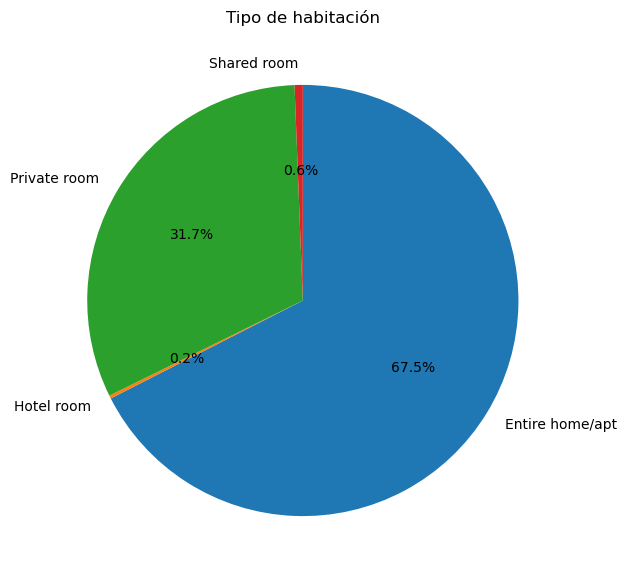

In [17]:
df_temp1 = data4.groupby("room_type").size().reset_index(name = "total")

plt.figure(figsize=(7, 7))
plt.pie(df_temp1["total"], labels=df_temp1["room_type"], autopct="%1.1f%%", startangle=90, counterclock=False)
plt.title("Tipo de habitación")

La mayoría de Airbnbs son casas o departamentos completos, seguidos por habitaciones privadas; juntos suman el $99.2\ \%$ del total de Airbnbs. El resto, el $0.8\ \%$ son habitaciones en hoteles o habitaciones compartidas. Esto probablemente refleje la tendencia de preferencias de los usuarios: la búsqueda de espacios privados.

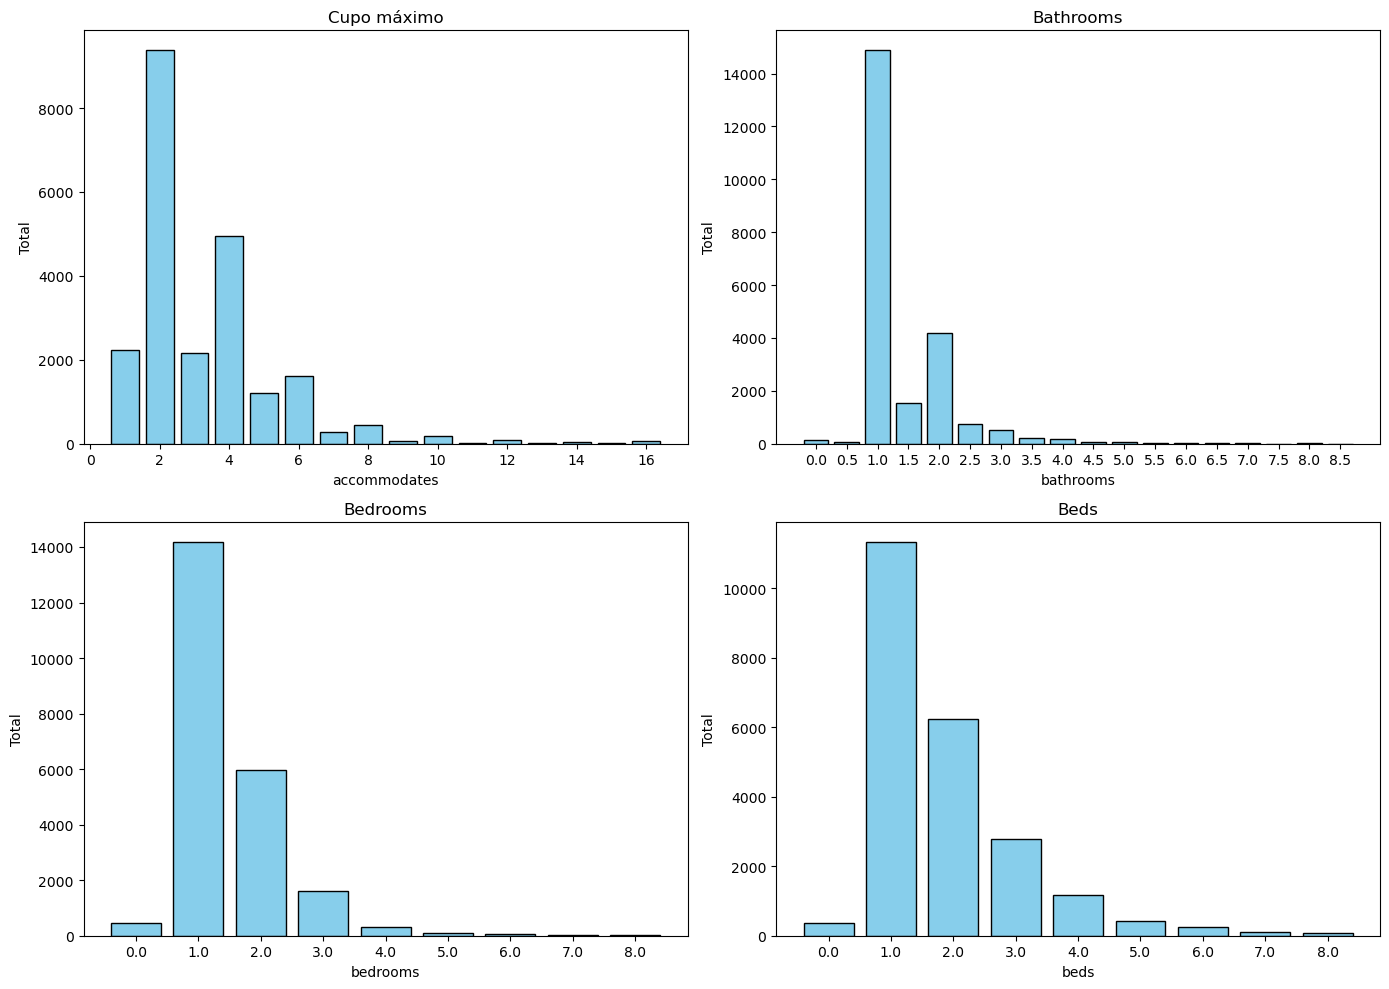

In [18]:
# Preparar los data frames.
df_temp2 = data4.groupby("accommodates").size().reset_index(name="total")
df_temp3 = data4.groupby("bathrooms").size().reset_index(name="total")
df_temp3 = df_temp3[df_temp3["bathrooms"] < 17]
df_temp3["bathrooms"] = df_temp3["bathrooms"].astype(str)
df_temp4 = data4.groupby("bedrooms").size().reset_index(name="total")
df_temp4 = df_temp4[df_temp4["bedrooms"] < 26]
df_temp4["bedrooms"] = df_temp4["bedrooms"].astype(str)
df_temp5 = data4.groupby("beds").size().reset_index(name="total")
df_temp5["beds"] = df_temp5["beds"].astype(str)

# Lista de dfs y títulos.
dfs = [(df_temp2, "accommodates", "Cupo máximo"), (df_temp3, "bathrooms", "Bathrooms"), (df_temp4, "bedrooms", "Bedrooms"), (df_temp5, "beds", "Beds")]

# Figura.
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (df, col, title) in zip(axes, dfs):
    ax.bar(df[col], df["total"], color="skyblue", edgecolor="black")
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel("Total")

plt.tight_layout()
plt.show()

- La gran mayoría de Airbnbs tienen cupo para entre 1-6 personas, entre 1-2 baños; 1-2 dormitoios, y 1-3 camas.
- En el caso de los baños, los "0.5" se refiere a baños compartidos con otros Airbnbs. Algunpos Airbnb reportan 0 dormitorios, quizá se trate de pequeños estudios o microdepartamentos, por ejemplo.
- La forma de la distribución del número de camas es similar a la forma de la distribución del número de dormitorios, lo cual muestra consistencia en los datos; no que haya una cama por cada dormitorio, sino que resultan proporcionales.

# Análisis temporal
- Serie de tiempo de la cantidad de servicios Airbnb aperturados por año.
- Mapa de la distribcuión del año de inicio del servicio.

In [19]:
data6 = data3.copy()
data6["host_since"] = pd.to_datetime(data6["host_since"], errors="coerce")
data6["host_since"].dtype

dtype('<M8[ns]')

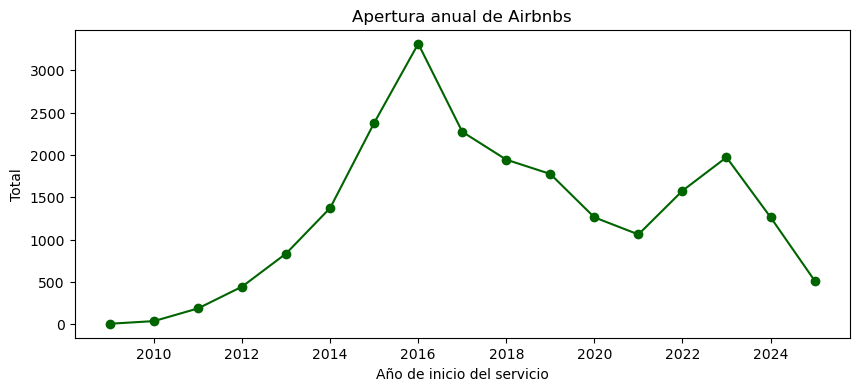

In [20]:
data_year = pd.DataFrame(data6["host_since"].dt.year)
df_temp6 = data_year.groupby("host_since").size().reset_index(name = "Total")

plt.figure(figsize = (10, 4))
plt.plot(df_temp6["host_since"], df_temp6["Total"], color = "darkgreen", marker = "o", markersize = 6)
plt.title("Apertura anual de Airbnbs")
plt.xlabel("Año de inicio del servicio")
plt.ylabel("Total");

Los primeros Airbnbs comenzaron a ofrecer su servicio en el año 2009, y hubo un crecimiento aproximadamente exponencial hasta el año 2016 (año en que alcanzó su pico). A partir del 2016 hubo una caída, con un ligero aumento en el año 2022 y 2023 y nuevamente caídas para los siguientes dos años.

In [21]:
# ====================== IMPORTS ======================
import numpy as np
import pandas as pd
import folium
from folium.plugins import Geocoder
import matplotlib
from matplotlib import colors

# ====================== DATA ======================
data6 = data3.copy()
data6["host_since"] = pd.to_datetime(data6["host_since"], errors="coerce")
data6 = data6.dropna(subset=["host_since", "latitude", "longitude"]).copy()
data6["host_year"] = data6["host_since"].dt.year.astype(int)

# ====================== GRID CONFIG ======================
CELL_KM = 2.0

GRID_COLOR = "black"
GRID_OPACITY = 0.0
GRID_WEIGHT = 1

lat0 = data6["latitude"].mean()
lon0 = data6["longitude"].mean()

km_per_deg_lat = 111.32
km_per_deg_lon = 111.32 * np.cos(np.deg2rad(lat0))

cell_deg_lat = CELL_KM / km_per_deg_lat
cell_deg_lon = CELL_KM / km_per_deg_lon

# Asignar celda a cada punto
data6["cell_lat"] = np.floor(data6["latitude"] / cell_deg_lat)
data6["cell_lon"] = np.floor(data6["longitude"] / cell_deg_lon)

# ====================== AGREGACIÓN ROBUSTA ======================
grid = (
    data6.groupby(["cell_lat", "cell_lon"])
    .agg(
        latitude=("latitude", "mean"),
        longitude=("longitude", "mean"),
        n=("host_year", "size"),
        year_median=("host_year", "median"),
        year_q25=("host_year", lambda s: s.quantile(0.25)),
        year_q75=("host_year", lambda s: s.quantile(0.75)),
        year_min=("host_year", "min"),
        year_max=("host_year", "max"),
    )
    .reset_index()
)

grid["year_iqr"] = grid["year_q75"] - grid["year_q25"]

# Filtrar celdas con pocos puntos
MIN_N = 5
grid = grid[grid["n"] >= MIN_N].copy()

# ====================== COLOR (AÑO MEDIANA) ======================
vmin = grid["year_median"].quantile(0.05)
vmax = grid["year_median"].quantile(0.95)
norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)

def truncate_cmap(cmap, minval=0.2, maxval=1.0, n=256):
    return colors.LinearSegmentedColormap.from_list(
        f"trunc_{cmap.name}", cmap(np.linspace(minval, maxval, n))
    )

base_cmap = matplotlib.colormaps.get_cmap("Blues")
cmap = truncate_cmap(base_cmap, 0.2, 1.0)

# ====================== MAPA ======================
m = folium.Map(location=[lat0, lon0], zoom_start=12, control_scale=True)
Geocoder(collapsed=False, add_marker=True).add_to(m)

# ====================== DIBUJAR CELDAS ======================
for _, row in grid.iterrows():

    lat_min = row["cell_lat"] * cell_deg_lat
    lat_max = lat_min + cell_deg_lat

    lon_min = row["cell_lon"] * cell_deg_lon
    lon_max = lon_min + cell_deg_lon

    folium.Rectangle(
        bounds=[[lat_min, lon_min], [lat_max, lon_max]],
        color=GRID_COLOR,
        weight=GRID_WEIGHT,
        opacity=GRID_OPACITY,
        fill=False
    ).add_to(m)

# ====================== MARCADORES ======================
for _, row in grid.iterrows():

    color_hex = colors.to_hex(cmap(norm(row["year_median"])))
    radius = 3 + np.log1p(row["n"])

    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=radius,
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.85,
        tooltip=(
            f"Mediana año host_since: {row['year_median']:.0f}<br>"
            f"IQR: {row['year_iqr']:.0f} años<br>"
            f"Rango: {int(row['year_min'])}–{int(row['year_max'])}<br>"
            f"Airbnbs en celda: {int(row['n'])}"
        )
    ).add_to(m)

m

- En el mapa anterior, la intensidad del color indica el año en que se inició el servicio (más intenso es más reciente). Nuevamente cada círculo representa la tendencia de un área geográfica de $4\ km^2$; para evitar sesgos, los datos se agregaron usando la mediana. Al pasar el mouse sobre cada círculo se puede observar la mediana del año y el rango intercuantílico, que es el intervalo en el que se ubica el $50\ \%$ de los datos.
- El tamaño del círculo es directamente proporcional a la cantidad de Airbnbs en la zona.
- Se puede observar que los Airbnbs de la zona oeste y suroeste de la ciudad tienden a ser más antiguos (con sus evidentes excepciones), mientras que los del lado este tienden a ser más recientes. Este patrón guarda una relación con el patrón de precios, pues anteriormente se vio que las zonas oeste y suroeste eran las más caras.

# Espacios y servicios

- Nube de palabras de los ``amenities``.
- Gráfica de porcentaje de asistencia en algunos espacios y servicios.

In [22]:
data7 = data3.copy()
data7_temp1 = data7[["id", "amenities"]].copy()
data7_temp1.head(2)

,id,amenities
0,35797,"[""Kitchen"", ""Resort access"", ""Hot water"", ""Cou..."
1,44616,"[""Free street parking"", ""Free parking on premi..."


A continuación procesaremos ``amenities`` para obtener un formato conveniente para hacer minería de texto.

In [23]:
data7_temp1["amenities_norm"] = (data7_temp1["amenities"].astype(str).apply(ast.literal_eval).apply(lambda lst: [re.sub(r"\s+", " ", a.lower().strip()) for a in lst]))
data7_temp1.head(2)

,id,amenities,amenities_norm
0,35797,"[""Kitchen"", ""Resort access"", ""Hot water"", ""Cou...","[kitchen, resort access, hot water, courtyard ..."
1,44616,"[""Free street parking"", ""Free parking on premi...","[free street parking, free parking on premises..."


Se quitaron comillas y se normalizó el texto pasándolo a minúsculas.

In [24]:
texto_completo = " ".join(data7_temp1["amenities_norm"].astype(str))

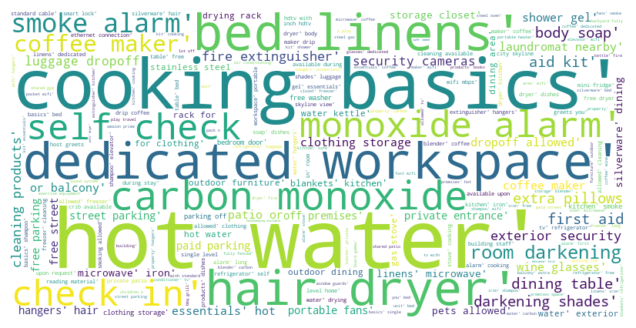

In [25]:
nube_palabras = WordCloud(width=800, height=400, background_color='white', stopwords={'and', 'and ', 'in', 'on', 'term', 'stays', 'in ', "'"}).generate(texto_completo)

plt.figure(figsize=(8, 4))
plt.imshow(nube_palabras, interpolation='bilinear')
plt.axis("off")
plt.show()

La nube de palabras muestra las palabras y bigramas más comunes: cafetera, agua caliente, utensilios básicos de cocina, espacio dedicado al trabajo, secadora de pelo, ropa de cama (sábanas y fundas), closet o ropero, productos de limpieza, detector de monóxido de carbono, detector de humo, etc. La historia que cuenta tiene que ver con servicios y utensilios básicos, de comodidad y de seguridad.

A continuación vamos a explorar servicios y espacios básicos en específico reportando su porcentaje de cumplimiento.

In [26]:
data7_temp1["amenities_text"] = data7_temp1["amenities_norm"].apply(lambda x: " ".join(x))

In [27]:
d = data7_temp1["amenities_text"].fillna("")
n = len(d)

amenities = [
    ("Cocina", r"\bkitchen\b"),
    ("TV", r"\btv\b"),
    ("Alarma de monóxido de carbono", r"monoxide alarm"),
    ("Mesa para comer", r"dining table"),
    ("Utensilios básicos de cocina", r"cooking basics"),
    ("Agua caliente", r"hot water"),
    ("WiFi", r"\bwifi\b"),
    ("Estacionamiento gratis", r"free parking"),
    ("Microondas", r"\bmicrowave\b"),
    ("Detector de humo", r"smoke alarm"),
    ("Piano", r"\bpiano\b"),
    ("Shampoo", r"\bshampoo\b"),
    ("Cubiertos", r"\bsilverware\b"),
    ("Secadora", r"\bdryer\b"),
    ("Refrigerador", r"\brefrigerator\b"),
    ("Cafetera", r"coffee maker"),
    ("Artículos básicos", r"\bessentials\b"),
    ("Ganchos para ropa", r"\bhangers\b"),
    ("Cámaras de seguridad", r"security cameras"),
    ("Vajilla", r"\bdishes\b"),
    ("Balcón", r"\bbalcony\b"),
    ("Patio", r"\bpatio\b"),
    ("Lavadora", r"\bwasher\b"),
    ("Plancha para ropa", r"\biron\b"),
    ("Estufa", r"\bstove\b"),
    ("Congelador", r"\bfreezer\b"),
    ("Productos de limpieza", r"cleaning products"),
    ("Ropa de cama", r"bed linens"),
    ("Horno", r"\boven\b"),
    ("Closet", r"\bcloset\b|clothing storage"),
    ("Tostadora", r"\btoaster\b"),
    ("Cuna", r"\bcrib\b"),
    ("Espacio para trabajar", r"\bworkspace\b"),
    ("Aire acondicionado", r"air conditioning"),
    ("Aire acondicionado portátil", r"portable air conditioning"),
]

df_temp_s = pd.DataFrame(amenities, columns=["Espacio o servicio", "pattern"])
df_temp_s["Porcentaje de cumplimiento"] = (df_temp_s["pattern"].apply(lambda p: d.str.contains(p, regex=True, na=False).sum() / n * 100).round(1))

df_temp_s = df_temp_s.drop(columns="pattern")

df_temp_s.sort_values(by = "Porcentaje de cumplimiento", ascending = False, inplace = True)

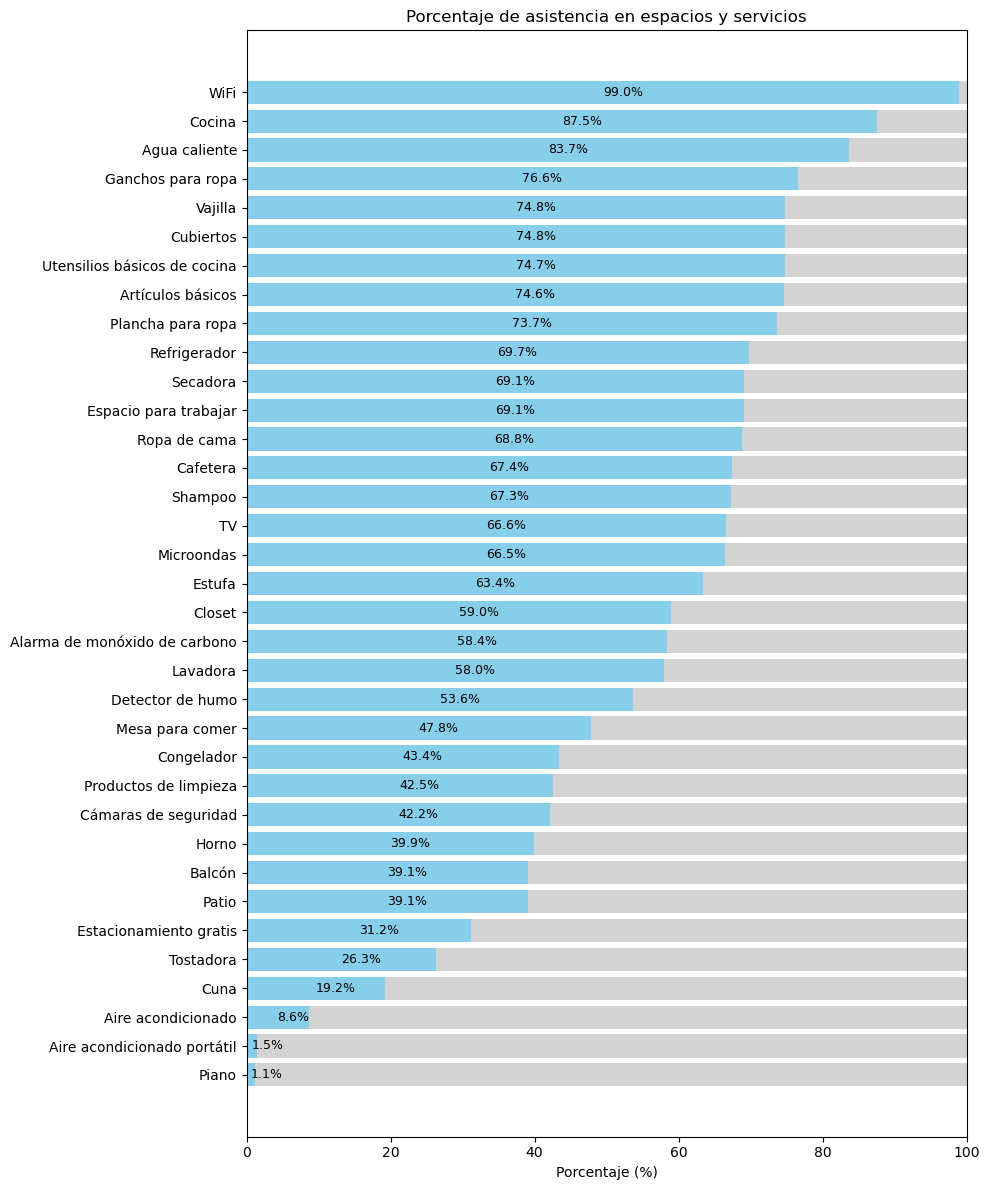

In [28]:
df_plot = df_temp_s.copy()
df_plot["Porcentaje no cubierto"] = 100 - df_plot["Porcentaje de cumplimiento"]
df_plot = df_plot.sort_values("Porcentaje de cumplimiento", ascending=True)

plt.figure(figsize=(10, 12))
plt.barh(df_plot["Espacio o servicio"], df_plot["Porcentaje de cumplimiento"], label="Cubierto", color = "skyblue")
plt.barh(df_plot["Espacio o servicio"], df_plot["Porcentaje no cubierto"], left=df_plot["Porcentaje de cumplimiento"], color = "lightgray")

for i, v in enumerate(df_plot["Porcentaje de cumplimiento"]):
    if v > 0:
        plt.text(v / 2, i, f"{v}%", va="center", ha="left", fontsize=9)

plt.title("Porcentaje de asistencia en espacios y servicios")
plt.xlabel("Porcentaje (%)")
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

- El WiFi es por mucho el servicio más ofrecido, estando prácticamente en todos los Airbnbs. Le siguen la cocina y el agua caliente, que se complementan con utensilios de cocina y comodidades de uso personal.
- Poco más de la mitad ofrecen servicios de seguridad, como detector de monóxido de carbono y detector de humo. Menos de la mitad ofrecen cámaras de seguridad.
- Menos de una tercera parte ofrece estacionamiento gratis.
- Algunos Airbnbs ofrecen algunas comodidades muy particulares, como cuna o piano.

# Ocupación mínima y máxima

- Distribución del requisito de ocupación mínima y máxima.

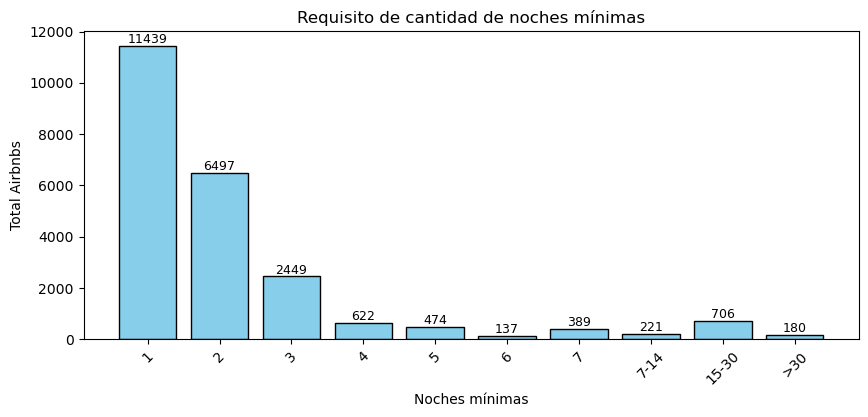

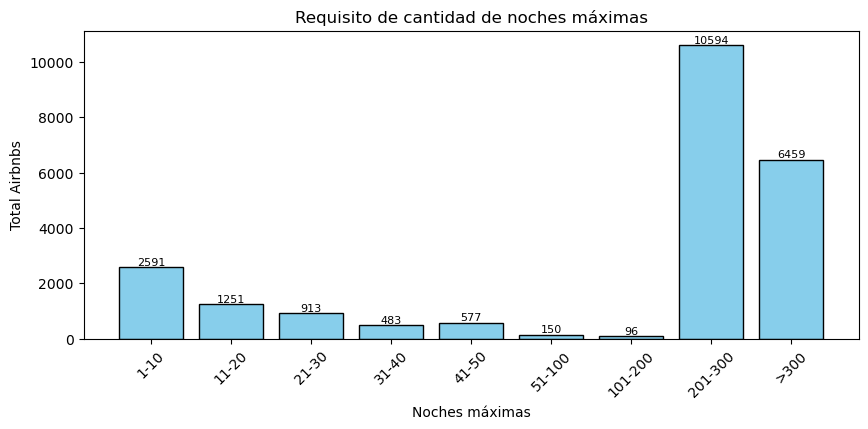

In [29]:
data8 = data3[["minimum_nights", "maximum_nights"]]

min_night = data8.groupby("minimum_nights").size().reset_index(name = "Total")
max_night = data8.groupby("maximum_nights").size().reset_index(name = "Total")


# Noches mínimas.
min_night.sort_values(by = "minimum_nights", ascending = True, inplace = True)

suma1 = suma2 = suma3 = suma4 = suma5 = suma6 = suma7 = suma8 = 0
for i in range(len(min_night)):
    v = min_night.iloc[i, 0]
    t = min_night.iloc[i, 1]
    if (v > 7) and (v <= 14):
        suma1 += t
    elif (v > 14) and (v <= 30):
        suma2 += t
    elif v > 30:
        suma3 += t

min_nights = min_night.head(7)

nights = ["7-14", "15-30", ">30"]
sumas  = [suma1, suma2, suma3]

for i in range(3):
    fila = pd.DataFrame({"minimum_nights": [nights[i]], "Total": [sumas[i]]})
    min_nights = pd.concat([min_nights, fila], ignore_index=True)

plt.figure(figsize=(10, 4))
bars = plt.bar(min_nights["minimum_nights"].astype(str), min_nights["Total"], color = "skyblue", edgecolor = "black")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{int(height)}", ha="center", va="bottom", fontsize=9)
    
plt.title("Requisito de cantidad de noches mínimas")
plt.xlabel("Noches mínimas")
plt.ylabel("Total Airbnbs")
plt.xticks(rotation = 45)
plt.show()

# Noches máximas.
max_night.sort_values(by = "maximum_nights", ascending = True, inplace = True)

suma0 = suma1 = suma2 = suma3 = suma4 = suma5 =suma6 = suma7 = suma8 = 0
for i in range(len(max_night)):
    v = max_night.iloc[i, 0]
    t = max_night.iloc[i, 1]
    if (v <= 30):
        suma0 += t
    if (v > 30) and (v <= 60):
        suma1 += t
    elif (v > 60) and (v <= 90):
        suma2 += t
    elif (v > 90) and (v <= 120):
        suma3 += t
    elif (v > 120) and (v <= 180):
        suma4 += t
    elif (v > 180) and (v <= 240):
        suma5 += t
    elif (v > 240) and (v <= 330):
        suma6 += t
    elif (v > 330) and (v <= 400):
        suma7 += t
    elif (v > 400):
        suma8 += t

nights = ["1-10", "11-20", "21-30", "31-40", "41-50", "51-100", "101-200", "201-300", ">300"]
sumas  = [suma0, suma1, suma2, suma3, suma4, suma5, suma6, suma7, suma8]

max_nights = pd.DataFrame()
for i in range(9):
    fila = pd.DataFrame({"maximum_nights": [nights[i]], "Total": [sumas[i]]})
    max_nights = pd.concat([max_nights, fila], ignore_index=True)

plt.figure(figsize=(10, 4))
bars = plt.bar(max_nights["maximum_nights"].astype(str), max_nights["Total"], color="skyblue", edgecolor="black")

for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{int(height)}", ha="center", va="bottom", fontsize=8)

plt.title("Requisito de cantidad de noches máximas")
plt.xlabel("Noches máximas")
plt.ylabel("Total Airbnbs")
plt.xticks(rotation=45);

- La gran mayoría tienen un requisito mínimo de entre 1-3 noches, con más de la mitad de ellas dando la opción de que solo se ocupe una noche. Algunos pocos piden como mínimo entre dos a cuatro semanas de uso, y algunos más piden más de un mes.
- La gran mayoría tiene un número bastante elevado de la cantidad de noches máximas para el uso; más de 17 000 superan incluso los 200 días permitidos.

# Tiempo y tasa de respuesta, aceptación y verificaciones

- Gráfica del tiempo de respuesta.
- Tabla de tasas de respuesta y aceptación por intervalos.
- Porcentaje de verificados.

Text(0.5, 1.0, 'Tiempo de respuesta')

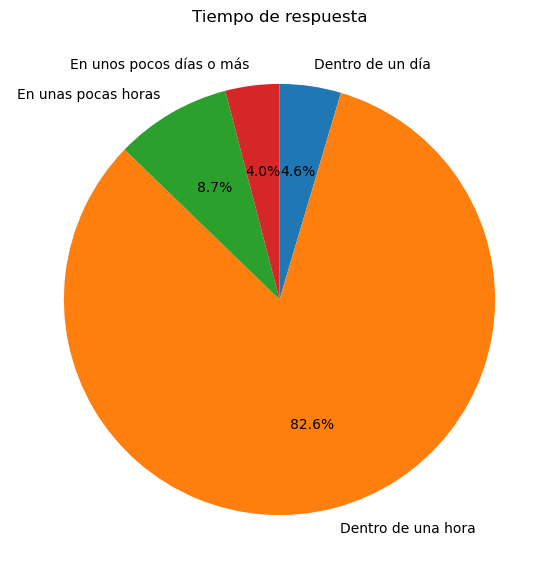

In [30]:
data9 = data3.copy()
mapa_texto = {1: "Dentro de una hora", 2: "En unas pocas horas", 3: "Dentro de un día", 4: "En unos pocos días o más"}
data9["host_response_time_txt"] = (data9["host_response_time"].map(mapa_texto).astype("category"))
df_temp9a = (data9.groupby("host_response_time_txt", observed=True).size().reset_index(name="total"))

plt.figure(figsize=(7, 7))
plt.pie(df_temp9a["total"], labels=df_temp9a["host_response_time_txt"], autopct="%1.1f%%", startangle=90, counterclock=False)
plt.title("Tiempo de respuesta")

La gran mayoría responde en menos de una hora. Apenas el 8.6 tarda un día o más en responder.

In [31]:
bins = np.arange(0, 101, 5)   # 0,5,...,100
labels = [f"{i}-{i+5}" for i in bins[:-1]]  # 0-5 ... 95-100
labels_desc = labels[::-1]

dtype_bins = pd.api.types.CategoricalDtype(categories=labels_desc, ordered=True)
resp = pd.to_numeric(data9["host_response_rate"], errors="coerce")
acc  = pd.to_numeric(data9["host_acceptance_rate"], errors="coerce")

resp_bin = pd.cut(resp, bins=bins, labels=labels, include_lowest=True, right=True).astype(dtype_bins)
acc_bin  = pd.cut(acc,  bins=bins, labels=labels, include_lowest=True, right=True).astype(dtype_bins)

resp_counts = resp_bin.value_counts(sort=False).reindex(labels_desc, fill_value=0)
acc_counts  = acc_bin.value_counts(sort=False).reindex(labels_desc, fill_value=0)

resp_pct = (resp_counts / resp_counts.sum() * 100).round(1)
acc_pct  = (acc_counts  / acc_counts.sum()  * 100).round(1)

tabla_final = pd.DataFrame({"intervalo": labels_desc, "host_response_rate": resp_pct.to_numpy(), "host_acceptance_rate": acc_pct.to_numpy()})
tabla_final.loc[len(tabla_final)] = ["Total", "100.0", "100.0"]
tabla_final = tabla_final.rename(columns={"host_response_rate": "Response rate (%)", "host_acceptance_rate": "Acceptance rate (%)"})

print(f"\nTabla de porcentajes por intervalo\n")
tabla_final


Tabla de porcentajes por intervalo



,intervalo,Response rate (%),Acceptance rate (%)
0,95-100,86.3,73.1
1,90-95,2.7,6.4
2,85-90,3.3,3.4
3,80-85,0.5,2.1
4,75-80,1.1,1.7
5,70-75,0.5,1.4
6,65-70,0.6,1.2
7,60-65,0.0,1.1
8,55-60,0.4,0.7
9,50-55,0.0,0.3


- El 86.3 % de los Airbnbs tienen una tasa de respuesta de entre 95 - 100 %, mientras que apenas el 73.1 % tiene una tasa de aceptación en ese intervalo.
- Aunque los porcentajes son bajos, resulta extraño que existen Airbnbs con tasas de respuesta y aceptación por debajo incluso del 20-25 %. Esta información podría ser útil para "podar" aquellos Airbnbs que casi no respondan y/o casi no acepten.

In [32]:
verified = len(data9[data9["host_identity_verified"] == "t"])
print(f"Se estima que el {round((verified / len(data9)) * 100, 1)} % de los Airbnbs están verificados.")
print(f'\nNota: Se "estima" porque solo se están considerando datos no nulos.')

Se estima que el 94.6 % de los Airbnbs están verificados.

Nota: Se "estima" porque solo se están considerando datos no nulos.


# Modelo explicativo del precio

A continuación se explora un modelo de regresión para explicar la variación del precio con el uso de algunas variables en particular. El objetivo no es elaborar un modelo robusto de predicción, sino más bien explorar cómo otras variables pueden explicar el precio. Este modelo no busca establecer relaciones causales, sino cuantificar asociaciones condicionales coherentes con los patrones observados en el análisis exploratorio.

Dado que el precio tiene una distribución complicada y bastante sesgada a la derecha, la variable respuesta será el logaritmo del precio, cuya distribución ya se exploró anteriormente. Construimos el modelo de la siguiente forma:

$$ Y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_{22} x_{i\ 22} + \varepsilon_i $$

donde

- $Y_i$ es el logaritmo del precio del Airbnb $i$.
- $\beta_0$ es el intercepto del modelo y representa el valor esperado del logaritmo del precio para un Airbnb ubicado en la alcaldía de referencia (Cuauhtémoc), manteniendo constantes el resto de las variables.
- $\beta_i$ es el coeficiente de la variable $i$.
- $x_1$ es el cupo máximo de personas (``accomodates``).
- $x_2$ es el número de baños (``bathrooms``).
- $x_3$ es el número de dormitorios (``bedrooms``).
- $x_4$ es el número de camas (``beds``).
- $x_5$ es la antiguedad en años (``host_since``).
- $x_6, x_7, x_8$ son variables indicadoras (dummies) que toman el valor de 1 si el tipo de habitación es "Private room" y "Shared room" y "Hotel room", respectivamente. Se omite "Entire home/apt" como categoría de referencia para evitar colinealidad perfecta.
- $x_9, x_8, ..., x_{24}$ son variables indicadoras (dummies) que toman el valor de 1 si el anuncio pertenece a las alcaldías Miguel Hidalgo, Benito Juárez, Coyoacán, Venustiano Carranza, Álvaro Obregón, Tlalpan, Gustavo A. Madero, Iztacalco, Cuajimalpa de Morelos, Azcapotzalco, Iztapalapa, Xochimilco, La Magdalena Contreras, Tláhuac y Milpa Alta, respectivamente, y 0 en caso contrario. La alcaldía Cuauhtémoc se omite como categoría de referencia para evitar colinealidad perfecta.
- $\varepsilon_i$ es un término de error con media cero que recoge factores no observados.

In [33]:
SHAPEFILE_ALCALDIAS = r"alcaldias/poligonos_alcaldias_cdmx.shp"
ALCALDIA_REF = "Cuauhtémoc"
ROOM_REF = "Entire home/apt"

# 0) Copia
df = data3.copy()

# 1) price -> numérico
df["price"] = (
    df["price"].astype(str)
      .str.replace("$", "", regex=False)
      .str.replace(",", "", regex=False)
      .str.strip()
)
df["price"] = pd.to_numeric(df["price"], errors="coerce")

# 2) corrige typo accommodates
if "accomodates" in df.columns and "accommodates" not in df.columns:
    df = df.rename(columns={"accomodates": "accommodates"})

# 3) host_since -> años
df["host_since"] = pd.to_datetime(df["host_since"], errors="coerce")
today = pd.Timestamp.today().normalize()
df["host_since_years"] = ((today - df["host_since"]).dt.days / 365.25)

# 4) y = log(price) (solo price válido)
df = df.dropna(subset=["price"]).copy()
df = df[df["price"] > 0].copy()
df["y"] = np.log(df["price"])

# 5) Spatial join: agrega 'Alcaldía' (UNA SOLA VEZ)
gdf_alc = gpd.read_file(SHAPEFILE_ALCALDIAS)
gdf_alc = gdf_alc.set_crs("EPSG:4326") if gdf_alc.crs is None else gdf_alc.to_crs("EPSG:4326")

# Detecta columna nombre alcaldía (si falla, imprime columnas y fija manual)
name_col = next(
    c for c in gdf_alc.columns
    if c.lower() != "geometry" and any(k in c.lower() for k in ["alcal", "nom", "name"])
)
gdf_alc = gdf_alc.rename(columns={name_col: "Alcaldía"})[["Alcaldía", "geometry"]].copy()

df_pts = df.dropna(subset=["longitude", "latitude"]).copy()
gdf_pts = gpd.GeoDataFrame(
    df_pts,
    geometry=gpd.points_from_xy(df_pts["longitude"], df_pts["latitude"]),
    crs="EPSG:4326"
)

df_geo = (
    gpd.sjoin(gdf_pts, gdf_alc, how="left", predicate="within")
      .drop(columns=["index_right"], errors="ignore")
      .dropna(subset=["Alcaldía"])
      .copy()
)

# 6) Dataset del modelo (DROP NA aquí)
model_cols = [
    "y",
    "accommodates", "bathrooms", "bedrooms", "beds", "host_since_years",
    "room_type", "Alcaldía"
]
df_ols = pd.DataFrame(df_geo[model_cols]).dropna().copy()

# 7) OLS + HC3 con referencias
formula = (
    "y ~ accommodates + bathrooms + bedrooms + beds + host_since_years + "
    f"C(room_type, Treatment(reference='{ROOM_REF}')) + "
    f"C(Alcaldía, Treatment(reference='{ALCALDIA_REF}'))"
)

ols = smf.ols(formula=formula, data=df_ols).fit(cov_type="HC3")
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     822.6
Date:                Wed, 24 Dec 2025   Prob (F-statistic):               0.00
Time:                        09:06:40   Log-Likelihood:                -18083.
No. Observations:               22119   AIC:                         3.621e+04
Df Residuals:                   22095   BIC:                         3.641e+04
Df Model:                          23                                         
Covariance Type:                  HC3                                         
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

- El $R^2$ ajustado es 0.491, lo cual significa que el modelo construido explica casi el 50 $\%$ de la variación total de precios.
- El p-value es muy pequeño, por lo que se concluye que el modelo sí tiene significancia estadística.
- El intercepto, $\beta_0$ = 6.73 representa el log-precio esperado de un Airbnb que es un Entire home/dept ubicado en la alcaldía Cuauhtémoc.
- En cuando a las variables dummies de ```room_type`` se concluye lo siguiente: *Hotel room* no tiene diferencias estadísticamente significativas respecto de un *Entire home/apt* (el p-valor es mayor que el nivel de significancia $\alpha = 0.05$. Por otro lado, *Private room* y *Shared room* si son estadísticamete diferentes de *Entire home/apt* (p-valor menor a 0.001, por lo que se rechaza la hipótesis nula de igualdad de los parámetros). Note que exp(-0.447) - 1 = -0.36 y exp(-1.323) - 1 = -0.734 (-0.447 y -1.323 son los parámetros estimados), lo cual significa que un *Private room* es 36 $\%$ más barato que un *Entire home/apt*, mientras que un *Shared room* es un 73.4 $\%$ más barato que un *Entire home/apt*. Resultados totalmente coherentes con la práctica.
- En cuanto a alcaldías, con un nivel de significancia $\alpha = 0.05$, todas tienen diferencias estadísticamente significativas de Cuauhtémoc (p-valor > 0.05). Con los coeficientes se hacen las siguientes estimaciones:
- Azcapotzalco, exp(-0.606) - 1 = -0.454, es 45.4 % más barata respecto de Cuauhtémoc;
- Benito Juárez, exp(-0.282) - 1 = -0.246, es 24.6 % más barato;
- Coyoacán, exp(-0.254) - 1 = -0.224, es 22.4 % más barato;
- Cuajimalpa de Morelos, exp(0.069) - 1 = 0.071, es 7.1 % más caro;
- Gustavo A. Madero, exp(-0.549) - 1 = -0.422, es 42.2 % más barato;
- Iztacalco, exp(-0.476) - 1 = -0.379, es 37.9 % más barato;
- Iztapalapa, exp(-0.756) - 1 = 0.53, es 53 % más barato;
- La Magdalena Contretas, exp(-0.280) - 1 = -0.244, es 24.4 % más barato;
- Miguel Hidalgo, exp(0.083) - 1 = 0.087, es el 8.7 % más caro;
- Milpa Alta, exp(-0.463) - 1 = -0.371, es el 37.1 % más barato;
- Tlalpan, exp(-0.462) - 1 = -0.370, es el 37 % más barato;
- Tláhuac, exp(-1.059) - 1 = - 0.653 es el 65.3 % más barato;
- Venustiano Carranza, exp(-0.548) - 1 = -0.422, es el 42.2 % más barato;
- Xochimilco, exp(-0.620) - 1 = -0.462, es el 46.2 % más barato;
- y Álvaro Obregón, exp(-0.216) - 1 = - 0.194, es el 19.4 % más barato;
- todo esto toma sentido de acuerdo con el análisis de precios y el análisis geográfico hecho anteriormente.
- El cupo máximo de personas (``accommodates``) es estadísticamente significativo en el modelo. El coeficiente indica que se estima que el costo aumenta aproximadamente el 13.7 % por persona extra.
- El coeficiente de ``Bathrooms`` estima que el precio aumenta 7.5 % aproximadamente por cada baño extra.
- El coeficiente de ``Bedrooms`` es muy similar al anterior, y estima que hay un aumento del 7.6 % en el costo por cada dormitorio extra.
- ``Beds`` tiene un coeficiente negativo, estimando que el costo disminuye 5.4 % por cada cama extra. Esto puede sugerir hacinamiento menor calidad del servicio asociado al espacio disponible.
- ``host_since_years`` también tiene un coeficiente negativo, estimando que el costo disminuye aproximadamente el 0.5 % por cada año más de antigüedad. Aunque el efecto es bajo, esto podría ser una estrategia competitiva.
- Los tests de normalidad (Jarque-Bera y Omnibus) no son críticos para consistencia; pero para inferencia uso SE robustos; además el tamaño muestral ayuda.
- Se utilizaron errores estándar robustos HC3 para corregir la heterocedasticidad, un fenómeno común en datos de precios donde la varianza del error aumenta con el nivel del precio, como en nuestro caso. HC3 pertenece a la familia de estimadores heterocedásticos consistentes y se caracteriza por ser más conservador que otras correcciones (HC0, HC1), ya que penaliza con mayor fuerza las observaciones influyentes y los diseños con muchas variables indicadoras. Esta elección permite obtener errores estándar, valores-p e intervalos de confianza confiables sin modificar los coeficientes estimados del modelo.

In [61]:
round(np.exp(-0.005) - 1, 3)

np.float64(-0.005)

In [34]:
RANDOM_STATE = 42
TOPK = 25

# Requiere df_geo del Fragmento 1.
required = {"y", "accommodates", "bathrooms", "bedrooms", "beds", "host_since_years", "room_type", "Alcaldía"}
missing = required - set(df_geo.columns)
if missing:
    raise ValueError(f"Faltan columnas en df_geo: {missing}. Ejecuta primero el Fragmento 1.")

num_features = ["accommodates", "bathrooms", "bedrooms", "beds", "host_since_years"]
cat_features = ["room_type", "Alcaldía"]

X = df_geo[num_features + cat_features].copy()
y = df_geo["y"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features),
    ],
    remainder="drop"
)

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    min_samples_leaf=5
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", rf)
])

pipe.fit(X_train, y_train)

# ============================================================
# IMPORTANCIAS POR FEATURE (DUMMIES + NUMÉRICAS)
# ============================================================
ohe = pipe.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(cat_features).tolist()
feat_names = num_features + cat_names

importances = pipe.named_steps["rf"].feature_importances_
imp = (
    pd.DataFrame({"feature": feat_names, "importance": importances})
      .sort_values("importance", ascending=False)
      .reset_index(drop=True)
)

print("\n================= Top importancias (por dummy) =================\n")
print(imp.head(TOPK).to_string(index=False))

# ============================================================
# (B) IMPORTANCIAS AGRUPADAS POR FACTOR (solo presentación)
# ============================================================
def _group_feature_name(f: str) -> str:
    # Numéricas: se quedan igual
    if f in num_features:
        return f
    # OneHotEncoder usa "col_val" por defecto, p.ej. "room_type_Entire home/apt"
    if f.startswith("room_type_"):
        return "room_type (total)"
    if f.startswith("Alcaldía_"):
        return "Alcaldía (total)"
    # Por si cambia el separador o formato
    if f.startswith("room_type"):
        return "room_type (total)"
    if f.startswith("Alcaldía"):
        return "Alcaldía (total)"
    return "otros"

imp_grouped = (
    imp.assign(group=imp["feature"].map(_group_feature_name))
       .groupby("group", as_index=False)["importance"].sum()
       .sort_values("importance", ascending=False)
       .reset_index(drop=True)
)

print("\n================= Importancias agrupadas por factor =================\n")
print(imp_grouped.to_string(index=False))


================= Top importancias (por dummy) =================

                        feature  importance
      room_type_Entire home/apt    0.315766
                      bathrooms    0.252101
               host_since_years    0.212377
                   accommodates    0.071507
        Alcaldía_Miguel Hidalgo    0.032474
            Alcaldía_Cuauhtémoc    0.026740
                       bedrooms    0.024015
                           beds    0.014996
          room_type_Shared room    0.008417
         Alcaldía_Benito Juárez    0.006943
 Alcaldía_Cuajimalpa de Morelos    0.005251
   Alcaldía_Venustiano Carranza    0.004821
               Alcaldía_Tlalpan    0.004072
              Alcaldía_Coyoacán    0.003804
           room_type_Hotel room    0.003030
        Alcaldía_Álvaro Obregón    0.002652
            Alcaldía_Iztapalapa    0.002571
          Alcaldía_Azcapotzalco    0.001815
     Alcaldía_Gustavo A. Madero    0.001648
         room_type_Private room    0.001434
         

- ``room_type`` es el factor más importante del modelo, con una importancia agregada del 32.6 %, seguido de ``bathrooms (25.2 %)`` y ``host_since_years`` (21.2 %); en conjunto, estos tres factores concentran aproximadamente el 79 % de la importancia total del modelo.

- La Alcaldía presenta una importancia agregada menor en el modelo no lineal, lo cual es consistente con su fragmentación en múltiples variables indicadoras. No obstante, como se observó en el modelo OLS, todas las alcaldías muestran efectos estadísticamente significativos respecto a la alcaldía de referencia, lo que confirma la relevancia de la ubicación.

- Variables como ``accommodates``, ``bedrooms`` y ``beds`` exhiben correlaciones moderadas entre sí y con ``bathrooms``; en el contexto del Random Forest, esta estructura correlacional, junto con posibles efectos no lineales, puede llevar a que uno de estos factores concentre una mayor proporción de la importancia explicativa, sin que ello implique irrelevancia de los restantes.

- En conjunto, el contraste no lineal mediante Random Forest confirma que el tipo de alojamiento es el principal determinante del precio, seguido por variables estructurales del inmueble y características del anfitrión. La ubicación geográfica mantiene un papel relevante, aunque su influencia se distribuye entre múltiples alcaldías. Estos resultados son coherentes con el modelo lineal explicativo y sugieren la presencia de relaciones no lineales e interacciones que el modelo OLS no captura completamente.

# Conclusiones

- El precio presenta una estructura espacial clara y no uniforme. Se observan alcaldías con niveles de precio sistemáticamente más altos (por ejemplo, Cuajimalpa y Cuauhtémoc) y zonas particularmente caras dentro de ellas (Polanco, Santa Fe, Lomas de Chapultepec, Condesa, entre otras). En contraste, alcaldías como Tláhuac, Iztapalapa o Azcapotzalco concentran precios relativamente más bajos. En términos generales, el centro, oeste y suroeste tienden a ser más costosos, mientras que norte, este y sureste concentran opciones más accesibles.

- La distribución del precio es marcadamente asimétrica hacia la derecha. Existen listados con precios muy altos que desplazan la media y separan fuertemente a ésta de la mediana; por ello, medidas robustas (mediana y rangos intercuartílicos) describen mejor el “precio típico” que la media simple. Este rasgo es consistente con mercados inmobiliarios y de hospedaje donde coexisten opciones estándar con un segmento premium pequeño pero influyente.

- La evolución temporal sugiere un ciclo de expansión y estabilización del mercado. Los primeros anfitriones aparecen alrededor de 2009 y el crecimiento se acelera hasta alcanzar un pico alrededor de 2016. Posteriormente se observa una disminución, con un repunte moderado en 2022–2023, y caídas nuevamente en los años siguientes. Este patrón es compatible con un mercado que pasa de fase de adopción a maduración, con fluctuaciones por contexto externo y cambios en la oferta.

- Antigüedad, espacio y precio se conectan espacialmente. Los listados del oeste y suroeste tienden a ser más antiguos (con excepciones), mientras que hacia el este predominan listados más recientes. Este gradiente temporal se alinea con el gradiente de precios: las zonas más caras concentran una mayor presencia de anfitriones antiguos, lo que sugiere un proceso de consolidación territorial del servicio en áreas de alta demanda.

- El desempeño operativo del anfitrión es alto en respuesta, pero heterogéneo en aceptación. Aproximadamente 83 % responde en la primera hora y más de 90 % dentro del primer día. Además, la verificación es elevada (cercana al 95 %) y la tasa de respuesta se concentra en valores altos (más del 90 % por encima de 85 %). En contraste, la tasa de aceptación presenta valores más bajos y extremos que merecen revisión, pues pueden indicar listados poco activos, restricciones no observadas o problemas de calidad del servicio.

- El modelo explicativo refuerza los hallazgos descriptivos. Al considerar simultáneamente ubicación, tipo de alojamiento y variables estructurales, el modelo confirma que la localización y el tipo de alojamiento siguen siendo determinantes relevantes del precio, junto con características físicas como baños/capacidad. En ese sentido, el modelo funciona como validación interna: no sustituye el análisis exploratorio, pero sí fortalece la coherencia entre secciones.

- Utilidad por tipo de usuario. El análisis aporta una base general reutilizable: para clientes, resulta especialmente útil la lectura conjunta de precio–zona–características–amenities; para la plataforma (Airbnb), los mapas y densidades permiten entender concentración territorial y madurez por zonas; y para control operativo, las métricas de respuesta/aceptación pueden servir para diseñar criterios de “poda” o filtros que identifiquen listados potencialmente inactivos o con baja calidad de atención.